In [1]:
## Exercise 4
# 1 Comment on your and other’s solution to Exercise 3


In [4]:
# 2 Density Tree and Decision Tree (20 points)
# Preliminaries
# import modules

import numpy as np
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node


In [5]:
# Density Tree

class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1
        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()
        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()   # pop the last term in the list
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                valid_features = np.where(np.min(node.data, axis=0) != np.max(node.data, axis=0))[0]
                if len(valid_features) > 0:
                    feature_indices = np.random.choice(valid_features, size=D_try, replace=False)
                    left, right = make_density_split_node(node=node, N=N, feature_indices=feature_indices)
                    stack.extend([left,right])
                else:
                    make_density_leaf_node(node=node, N=N)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node=node, N=N)
    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise
        if (self.box[0] <= x).all() and (x <= self.box[1]).all():
            p = leaf.response * self.prior
        else:
            p = 0
        return p

def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape                              # self.root.data
    m, M = node.box   # m: min values ; M: max values   # self.root.box
    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary.
        # Duplicated terms might confuse the splitting processes which cannot determine which side should be assigned
        # since the mean of duplicated value will be itself.
        # Also, np.unique() can automatically sort the value.
        data_unique = np.unique((node.data[:, j]))     # N x 1
        # Compute candidate thresholds
        tj = np.mean([data_unique[:-1],data_unique[1:]], axis=0)     
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            mL, ML = m.copy(), M.copy()
            ML[j,] = t
            mR, MR = m.copy(), M.copy()
            mR[j,] = t
            VL = np.prod(ML - mL)
            VR = np.prod(MR - mR)
            NL = node.data[node.data[:,j] < t, : ].shape[0]
            NR = node.data[node.data[:,j] > t, : ].shape[0]
            errL = (NL/(N*VL)) * (NL/N - 2*((NL-1)/(N-1)))
            errR = (NR/(N*VR)) * (NR/N - 2*((NR-1)/(N-1)))
            # Compute the error
            loo_error = errL + errR
            # choose the best threshold that
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = t
    # create children
    left = Node()
    right = Node()
    #####  np.shares_memory()
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    m_new = m.copy()
    M_new = M.copy()
    M_new[j_min,] =  t_min
    m_new[j_min,] = t_min  # New    #m_new[:,j_min] = t_min
    left.data =  node.data[node.data[:,j_min] < t_min , :] # store data in left node -- for subsequent splits
    left.box = node.box[0].copy(), M_new.copy()  # store bounding box in left node
    right.data = node.data[node.data[:,j_min] > t_min , :]
    right.box = m_new.copy(), node.box[1].copy()
    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min
    # return the children (to be placed on the stack)
    return left, right

def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    v = np.prod(node.box[1] - node.box[0])
    node.response = n/(N*v)    # likelihood



In [6]:
# Decision Tree

class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision
        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                valid_features = np.where(np.min(node.data, axis=0) != np.max(node.data, axis=0))[0]
                feature_indices = np.random.choice(valid_features, size=D_try, replace=False)
                left, right = make_decision_split_node(node=node, feature_indices=feature_indices)
                stack.extend([left,right])
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node=node,minlength=len(set(labels)))
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        p = leaf.response / leaf.N
        return p

def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    e_min = float("inf")
    j_min, t_min = None, None
    # find best feature j (among 'feature_indices') and best threshold t for the split
    for j in feature_indices:
        data_unique = np.unique((node.data[:, j]))     # N x 1
        # Compute candidate thresholds
        tj = np.mean([data_unique[:-1],data_unique[1:]], axis=0)     
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            NL = len(node.labels[node.data[:,j] < t])
            NR = len(node.labels[node.data[:,j] > t])
            NLk = node.labels[node.data[:,j] < t]
            NRk = node.labels[node.data[:,j] > t]
            errGL = NL*(1-sum( [(len(NLk[NLk==k]) / NL) ** 2 for k in list(set(node.labels))] ))
            errGR = NR*(1-sum( [(len(NRk[NRk==k]) / NR) ** 2 for k in list(set(node.labels))] ))
            # Compute the error
            gini_error = errGL + errGR
            # choose the best threshold that
            if gini_error < e_min:
                e_min = gini_error
                j_min = j
                t_min = t
    # create children
    left = Node()
    right = Node()
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] < t_min,:]
    left.labels = node.labels[node.data[:,j_min] < t_min]
    right.data = node.data[node.data[:,j_min] > t_min,:]
    right.labels = node.labels[node.data[:,j_min] > t_min]
    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min
    # return the children (to be placed on the stack)
    return left, right    

def make_decision_leaf_node(node,minlength):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.data)
    node.response = np.bincount(node.labels,minlength=minlength)

def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return len(set(node.labels)) == 1



In [7]:
# 3 Evaluation of Density Tree and Decision Tree (6 points)

from sklearn.datasets import load_digits
from sklearn import model_selection
import pandas as pd  
import matplotlib.pyplot as plt
digits = load_digits()
data = digits["data"]
target = digits["target"]
target_names = digits["target_names"]
prior = [len(target[target == d]) / len(target) for d in target_names]


In [8]:
# 4 Density Forest and Decision Forest (8 points)
# Train a generative classifier using 10 instances of DensityTree 

def DSTclassifier(X_train,Y_train,X_test,Y_test,n_min,return_error):
    DSTclassifier = [DensityTree() for _ in list(set(Y_train))]
    [DSTclassifier[d].train(data=X_train[Y_train == list(set(target))[d],:], prior=prior[d], n_min=n_min) for d in range(len(set(Y_train)))]
    y_test = [DSTclassifier[d].predict(X_test[i,:]) for i in range(len(X_test)) for d in range(len(set(Y_train))) ]
    y_test = np.array(y_test).reshape([len(X_test),len(set(Y_train))])
    y_test = np.argmax(y_test, axis=1)
    if return_error == True:
        err = (len(Y_test) - np.sum(y_test == Y_test)) / len(Y_test)
        return y_test, err
    else:
        return y_test
# Train a discriminative classifier using one instance of DecisionTree. 

def DCTclassifier(X_train,Y_train,X_test,Y_test,n_min,return_error):
    DCTclassifier = DecisionTree() 
    DCTclassifier.train(data=X_train,labels=Y_train,n_min=n_min)
    y_test = [DCTclassifier.predict(X_test[i,:]) for i in range(len(X_test))]
    y_test = np.array(y_test).reshape([len(X_test),len(set(Y_train))])
    y_test = np.argmax(y_test, axis=1)
    if return_error == True:
        err = (len(Y_test) - np.sum(y_test == Y_test)) / len(Y_test)
        return y_test, err
    else:
        return y_test


In [9]:
# Plot the confusion matrix

X_train = X_test = data
Y_train = Y_test = target
yDST, errDST = DSTclassifier(X_train,Y_train,X_test,Y_test,n_min=20,return_error=True)
yDCT, errDCT = DCTclassifier(X_train,Y_train,X_test,Y_test,n_min=20,return_error=True)


In [10]:
confDST = pd.crosstab(pd.Series(Y_test, name='Truth'), pd.Series(yDST, name='DensityTree Predicted'))
confDST


DensityTree Predicted,0,1,2,3,4,5,6,7,8,9
Truth,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,128,2,1,6,0,0,2,39,4
2,0,22,93,23,0,4,0,0,35,0
3,0,3,0,104,0,2,0,5,49,20
4,0,1,0,0,162,0,0,16,1,1
5,0,1,0,7,2,118,0,9,22,23
6,0,1,0,0,0,0,179,0,1,0
7,0,1,0,0,5,3,0,170,0,0
8,0,4,0,8,0,1,0,10,151,0


In [11]:
confDCT = pd.crosstab(pd.Series(Y_test, name='Truth'), pd.Series(yDST, name='DecisionTree Predicted'))
confDCT


DecisionTree Predicted,0,1,2,3,4,5,6,7,8,9
Truth,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,128,2,1,6,0,0,2,39,4
2,0,22,93,23,0,4,0,0,35,0
3,0,3,0,104,0,2,0,5,49,20
4,0,1,0,0,162,0,0,16,1,1
5,0,1,0,7,2,118,0,9,22,23
6,0,1,0,0,0,0,179,0,1,0
7,0,1,0,0,5,3,0,170,0,0
8,0,4,0,8,0,1,0,10,151,0


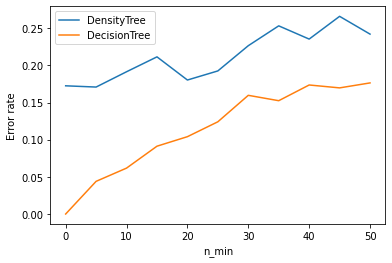

In [12]:
# Plot the performance under various n_min

n_min = [n for n in range(0,55,5)]
errA,errB = [], []

for n in n_min:
    yDST, errDST = DSTclassifier(X_train,Y_train,X_test,Y_test,n_min=n,return_error=True)
    yDCT, errDCT = DCTclassifier(X_train,Y_train,X_test,Y_test,n_min=n,return_error=True)
    errA.append(errDST)
    errB.append(errDCT)

plt.figure()
plt.plot(n_min, errA, label='DensityTree')
plt.plot(n_min, errB, label='DecisionTree')
plt.xlabel('n_min')
plt.ylabel('Error rate')
plt.legend()
plt.show()


In [13]:
# 4 Density Forest and Decision Forest (8 points)
# Density and Decision Forest

class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]
    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bp = np.random.choice(len(data), size=len(data), replace=True)
            bpdata = data[bp,:]
            tree.train(data=bpdata, prior=prior, n_min=n_min)
    def predict(self, x):
        # compute the ensemble prediction
        p = np.mean([tr.predict(x) for tr in self.trees],axis=0)
        return p

class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bp = np.random.choice(len(data), size=len(data), replace=True)
            bpdata = data[bp,:]
            bplabels = labels[bp,]
            tree.train(data=bpdata, labels=bplabels, n_min=n_min)
    def predict(self, x):
        # compute the ensemble prediction
        #np.bincount(np.array([tr.predict(x) for tr in self.trees])).argmax()
        p = np.mean([tr.predict(x) for tr in self.trees],axis=0)
        return p


In [14]:
# 5 Evaluation of Density Forest and Decision Forest (6 points)
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
# Train a generative classifier using 10 instances of DensityForest 

def DSFclassifier(X_train,Y_train,X_test,Y_test,n_trees,return_error):
    DSFclassifier = [DensityForest(n_trees=n_trees) for _ in list(set(Y_train))]
    [DSFclassifier[d].train(data=X_train[Y_train == list(set(target))[d],:], prior=prior[d], n_min=20) for d in range(len(set(Y_train)))]
    y_test = [DSFclassifier[d].predict(X_test[i,:]) for i in range(len(X_test)) for d in range(len(set(Y_train))) ]
    y_test = np.array(y_test).reshape([len(X_test),len(set(Y_train))])
    y_test = np.argmax(y_test, axis=1)
    if return_error == True:
        err = (len(Y_test) - np.sum(y_test == Y_test)) / len(Y_test)
        return y_test, err
    else:
        return y_test
# Train a discriminative classifier using one instance of DecisionForest. 

n_trees = 5

def DCFclassifier(X_train,Y_train,X_test,Y_test,n_trees,return_error):
    DCFclassifier = DecisionForest(n_trees=n_trees) 
    DCFclassifier.train(data=X_train,labels=Y_train,n_min=0)
    y_test = [DCFclassifier.predict(X_test[i,:]) for i in range(len(X_test))]
    y_test = np.array(y_test).reshape([len(X_test),len(set(Y_train))])
    y_test = np.argmax(y_test, axis=1)
    if return_error == True:
        err = (len(Y_test) - np.sum(y_test == Y_test)) / len(Y_test)
        return y_test, err
    else:
        return y_test



In [15]:
X_train = X_test = data
Y_train = Y_test = target
yDSF, errDSF = DSFclassifier(X_train,Y_train,X_test,Y_test,n_trees=20,return_error=True)
yDCF, errDCF = DCFclassifier(X_train,Y_train,X_test,Y_test,n_trees=20,return_error=True)


In [16]:
confDSF = pd.crosstab(pd.Series(Y_test, name='Truth'), pd.Series(yDSF, name='DensityForest Predicted'))
confDSF


DensityForest Predicted,0,1,2,3,4,5,6,7,8,9
Truth,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,172,4,2,0,0,0,0,3,1
2,0,1,151,7,0,0,0,0,18,0
3,0,0,4,152,0,2,0,4,15,6
4,0,3,0,0,165,0,0,13,0,0
5,0,1,0,3,0,167,0,2,7,2
6,0,1,0,0,0,0,180,0,0,0
7,0,0,0,0,0,0,0,178,1,0
8,0,5,0,1,0,1,0,1,164,2


In [17]:
confDCF = pd.crosstab(pd.Series(Y_test, name='Truth'), pd.Series(yDCF, name='DecisionForest Predicted'))
confDCF


DecisionForest Predicted,0,1,2,3,4,5,6,7,8,9
Truth,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,182,0,0,0,0,0,0,0,0
2,0,0,177,0,0,0,0,0,0,0
3,0,0,0,183,0,0,0,0,0,0
4,0,0,0,0,181,0,0,0,0,0
5,0,0,0,0,0,182,0,0,0,0
6,0,0,0,0,0,0,181,0,0,0
7,0,0,0,0,0,0,0,179,0,0
8,0,0,0,0,0,0,0,0,174,0


In [18]:
# Compare results with the confusion matrix obtained from sklearn.ensemble.RandomForestClassifier with 20 trees

from sklearn.ensemble import RandomForestClassifier

def RDFclassifier(X_train,Y_train,X_test,Y_test,n_trees,return_error):
    RDFclassifier = RandomForestClassifier(n_estimators=n_trees) 
    RDFclassifier.fit(X_train,Y_train)
    y_test = RDFclassifier.predict(X_test)
    if return_error == True:
        err = (len(Y_test) - np.sum(y_test == Y_test)) / len(Y_test)
        return y_test, err
    else:
        return y_test


In [19]:
yRDF, errRDF = RDFclassifier(X_train,Y_train,X_test,Y_test,n_trees=20,return_error=True)


In [20]:
confRDF = pd.crosstab(pd.Series(Y_test, name='Truth'), pd.Series(yRDF, name='RandomForest Predicted'))
confRDF


RandomForest Predicted,0,1,2,3,4,5,6,7,8,9
Truth,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,182,0,0,0,0,0,0,0,0
2,0,0,177,0,0,0,0,0,0,0
3,0,0,0,183,0,0,0,0,0,0
4,0,0,0,0,181,0,0,0,0,0
5,0,0,0,0,0,182,0,0,0,0
6,0,0,0,0,0,0,181,0,0,0
7,0,0,0,0,0,0,0,179,0,0
8,0,0,0,0,0,0,0,0,174,0
